<a href="https://colab.research.google.com/github/viveksingh054/Personalized-healthcare-recommendation/blob/main/Personalized_healthcare_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ü©∫ Personalized Healthcare Recommendations Project



## Step 2: Dataset Loading & Initial Understanding
**Goal:** Load the dataset, understand its structure and quality, so that the further analysis can move in the right direction.


Step 2.1 ‚Äì Import libraries and Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


In [ ]:
df = pd.read_csv("blood.csv")


Step 2.2 ‚Äì Dataset Size

In [ ]:
print("Shape:", df.shape)

Shape: (748, 5)


Insight: Row count = number of samples/patients, Column count = number of available features.

Step 2.3 ‚Äì Column Names

In [ ]:
print("Columns:", df.columns.tolist())

Columns: ['Recency', 'Frequency', 'Monetary', 'Time', 'Class']


Insight: Important for understanding the actual feature names, and helpful in detecting spelling mistakes or extra spaces.

Step 2.4 ‚Äì Data Types + Null Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


Insight: Provides a direct snapshot of data types (int, float, object) and missing values. This forms the foundation for preprocessing.

Step 2.5 ‚Äì Statistical Summary

In [ ]:
df.describe()

Recency   Frequency      Monetary        Time       Class
count  748.000000  748.000000    748.000000  748.000000  748.000000
mean     9.506684    5.516043   1378.676471   34.284759    0.237968
std      8.095396    5.841825   1459.826781   24.380307    0.426124
min      0.000000    1.000000    250.000000    2.000000    0.000000
25%      2.750000    2.000000    500.000000   16.000000    0.000000
50%      7.000000    4.000000   1000.000000   28.000000    0.000000
75%     14.000000    7.000000   1750.000000   50.000000    0.000000
max     74.000000   50.000000  12500.000000   99.000000    1.000000

Insight: Helps in understanding the spread, mean, minimum, maximum, and percentiles of continuous variables. It also provides an idea about potential outliers.

Step 2.6 ‚Äì Missing Values Count

In [ ]:
df.isnull().sum()

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64

Insight: This step reveals whether missing data needs to be imputed or handled.

Step 2.7 ‚Äì Duplicates Check

In [ ]:
df.duplicated().sum()

np.int64(215)

Insight: If the dataset contains duplicate records, the model may become biased ‚Üí such records will be removed during preprocessing.

Step 2.8 ‚Äì Unique Values Count

In [ ]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Recency: 31 unique values
Frequency: 33 unique values
Monetary: 33 unique values
Time: 79 unique values
Class: 2 unique values


Insight:
The diversity of numerical and categorical columns has been checked.

Recency: 31 unique values ‚Üí good variability.

Frequency: 33 unique values ‚Üí good variability.

Monetary: 33 unique values ‚Üí consistent with donation amounts.

Time: 79 unique values ‚Üí wide spread across donors.

Class: 2 unique values ‚Üí binary target variable (0 and 1).

‚úÖ Since no column has only a single unique value, all features are useful for further analysi

Step 2.9 ‚Äì Target Variable Balance (Class Imbalance Check)

In [ ]:
df['Class'].value_counts(normalize=True) * 100

Class
0    76.203209
1    23.796791
Name: proportion, dtype: float64

Insight:
The target variable (Class) is imbalanced:

Class 0: 76.2%

Class 1: 23.8%

This imbalance can significantly impact model performance, as the model may get biased towards the majority class. To address this, techniques like SMOTE, oversampling, or class-weight adjustment may be required during preprocessing.

Step 2.10 ‚Äì Quick Correlation Snapshot

In [ ]:
df.corr()['Class'].sort_values(ascending=False)

Class        1.000000
Frequency    0.218949
Monetary     0.218633
Time        -0.035653
Recency     -0.279869
Name: Class, dtype: float64

Insight:
This gives an early idea of which features are more correlated with the target variable (Class).

Frequency (0.2189) and Monetary (0.2186) show a positive correlation with Class ‚Üí donors who donated more frequently and in larger amounts are more likely to donate again.

Recency (-0.2798) has a negative correlation ‚Üí the longer the gap since the last donation, the less likely a donor is to donate again.

Time (-0.0356) shows almost no relationship with Class ‚Üí being part of the program longer does not strongly influence future donations.

‚úÖ This step helps prioritize features that might be more predictive during model building.

# **Cleaning Step 1 ‚Äì Outlier Detection**
üéØ Goal: Identify extreme or unrealistic values in features (Recency, Frequency, Monetary, Time).

If too many outliers exist, the model may become biased.

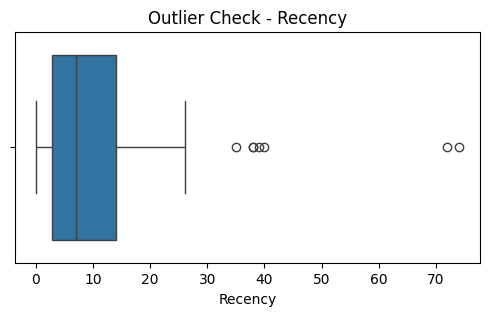

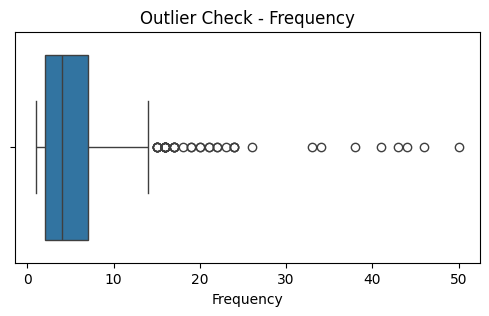

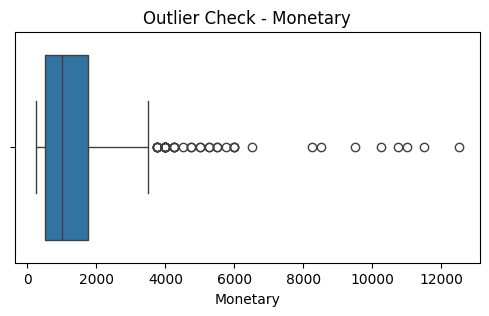

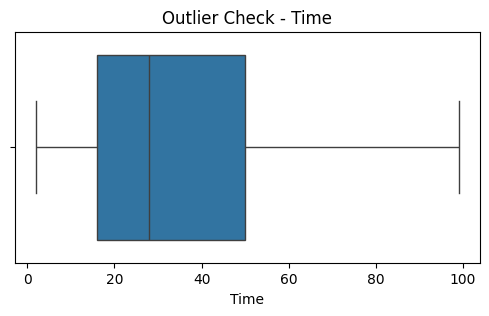

In [ ]:
for col in ["Recency", "Frequency", "Monetary", "Time"]:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Check - {col}")
    plt.show()

üëâ Conclusion Insight:
Outliers exist, especially in Frequency and Monetary, but they represent real donor behaviors (heavy donors). Hence, they should be retained and normalized, not removed.

# **Target Balance Check (final cleaning step)**

Class Distribution:
 Class
0    570
1    178
Name: count, dtype: int64
Class Distribution (%):
 Class
0    76.203209
1    23.796791
Name: count, dtype: float64


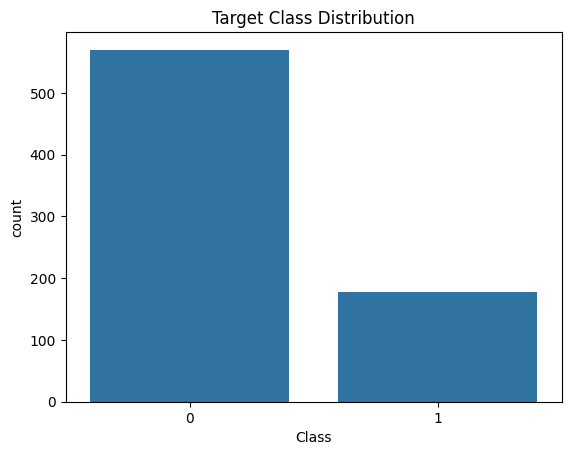

In [ ]:
class_counts = df["Class"].value_counts()
print("Class Distribution:\n", class_counts)
print("Class Distribution (%):\n", class_counts/len(df)*100)

sns.countplot(x="Class", data=df)
plt.title("Target Class Distribution")
plt.show()

‚úÖ Conclusion

cleaning step for target balance is complete üéâ

The dataset is now clean and ready for EDA (Exploratory Data Analysis).

Just remember: When building the model, it will be important to handle class imbalance.

# **Step 3: Exploratory Data Analysis (EDA)**

Step 3.1 ‚Äì Distribution of Numerical Features

Goal: Understand feature distributions & detect skewness/outliers.

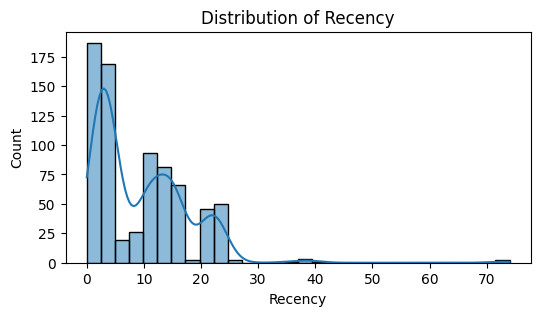

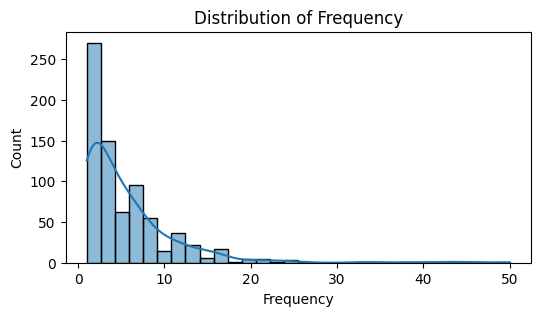

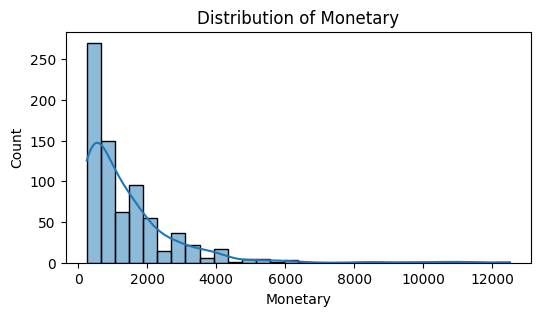

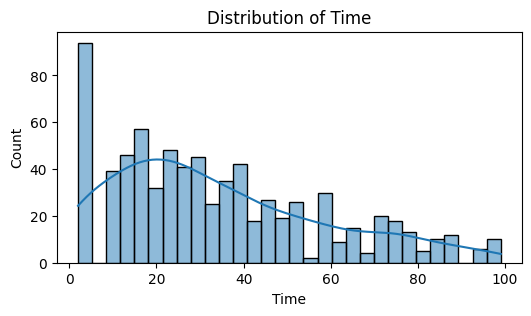

In [ ]:
num_cols = ["Recency", "Frequency", "Monetary", "Time"]

import matplotlib.pyplot as plt
import seaborn as sns

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


# **Insight**

High Recency means the donor hasn‚Äôt donated in a long time.

Frequency/Monetary will show skewness (most people donate less, while a few heavy donors appear as outliers).

Time indicates how many months the donor has been active.

# Step 3.2 ‚Äì Correlation Heatmap
Goal: Find relationships between features & target.

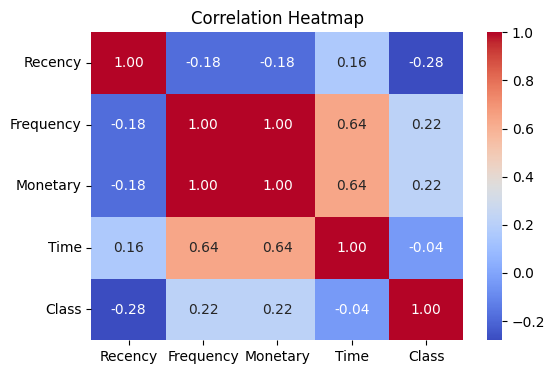

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Insight:

Frequency and Monetary are expected to have a strong positive correlation (more frequent donations = higher donation volume).

Class correlation check: Recency is likely to be negatively correlated (the more recent the donation, the higher the chance of being an active donor).

# Step 3.3 ‚Äì Relationship of Features with Target (Class)

Goal: Compare donor vs non-donor across features.

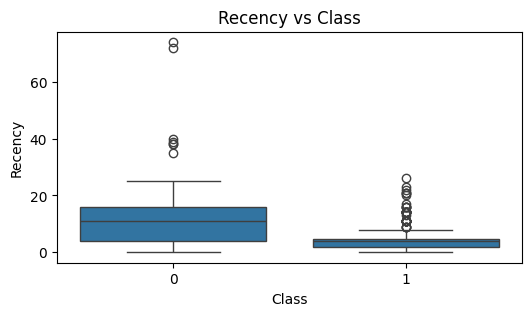

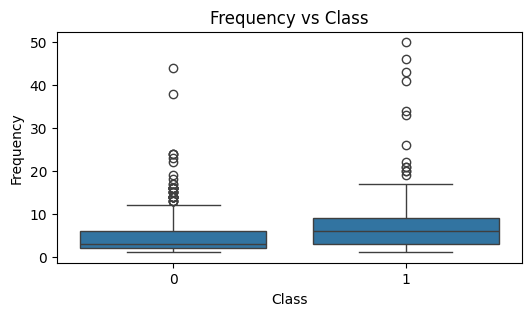

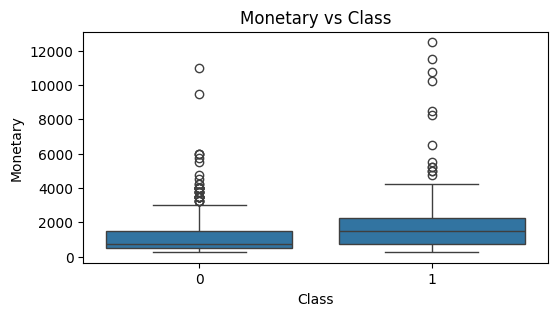

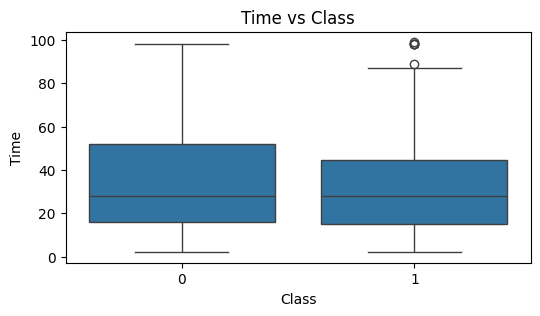

In [ ]:
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x="Class", y=col, data=df)
    plt.title(f"{col} vs Class")
    plt.show()

Insight:

Donors (Class = 1): Typically have low Recency (they donated recently), along with higher Frequency and Monetary values.

Non-donors (Class = 0): Tend to show high Recency (they donated a long time ago), with lower Frequency and Monetary values.

# Step 3.4 ‚Äì Pairplot (Feature Interactions)

üéØ Goal: Visualize multivariate relationships.

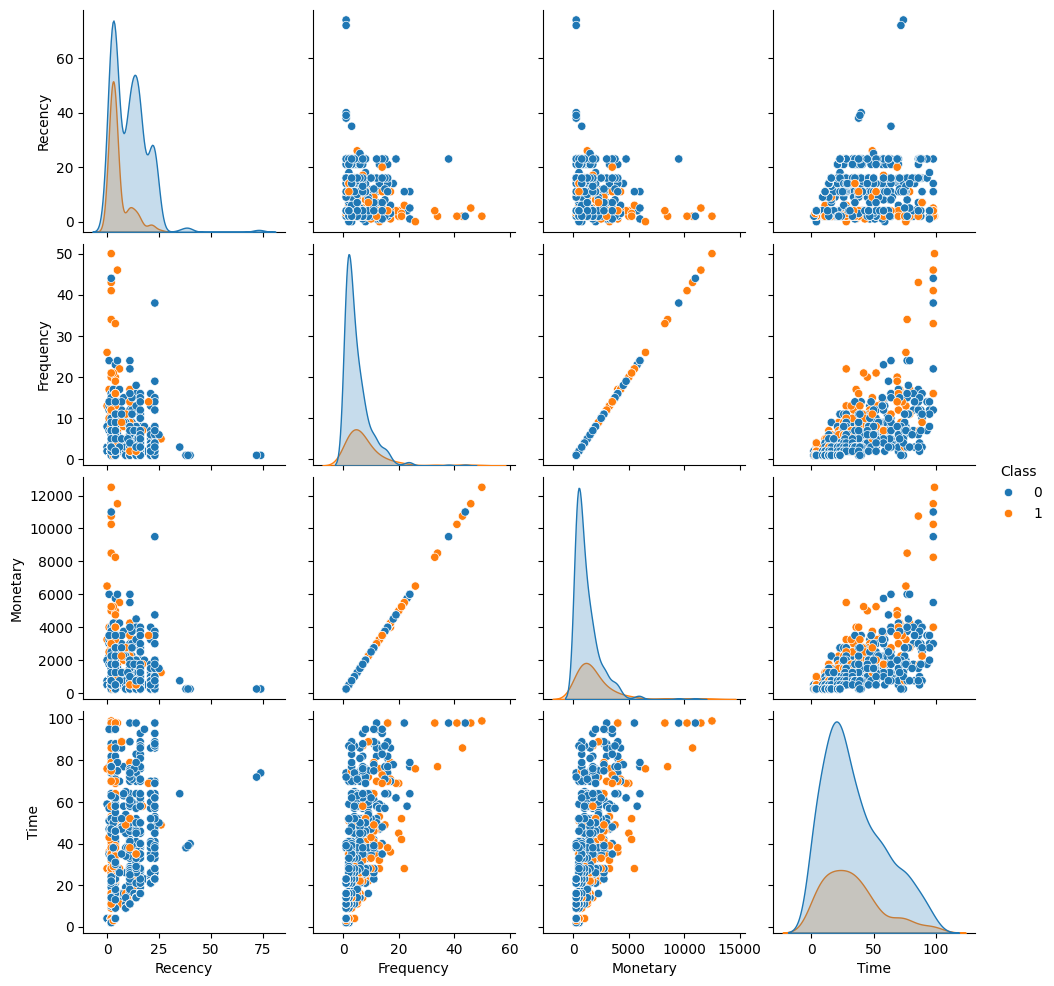

In [ ]:
sns.pairplot(df, hue="Class", vars=num_cols)
plt.show()

Insight:
A clear separation is visible between donors and non-donors based on Recency, Frequency, and Monetary behavior.
üëâ This distinction is very helpful for modeling, as the features already show strong discriminatory power for predicting donation likelihood.

Step 3.5 ‚Äì Target (Class) with Frequency Distribution

Goal: See donor engagement pattern.

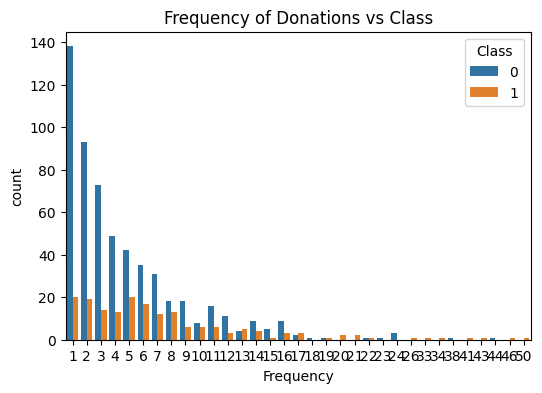

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="Frequency", hue="Class", data=df)
plt.title("Frequency of Donations vs Class")
plt.show()

Insight:

Class 1 donors mostly high frequency wale honge.

Class 0 wale kam frequency donors.

3.6 ‚Äì Target-wise Feature Distributions (KDE plots)

Goal: Compare how features differ for donors vs non-donors.

/tmp/ipython-input-274312589.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==0][col], label="Class 0", shade=True)
/tmp/ipython-input-274312589.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==1][col], label="Class 1", shade=True)


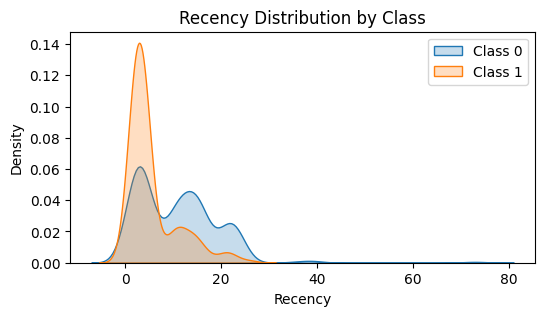

/tmp/ipython-input-274312589.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==0][col], label="Class 0", shade=True)
/tmp/ipython-input-274312589.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==1][col], label="Class 1", shade=True)


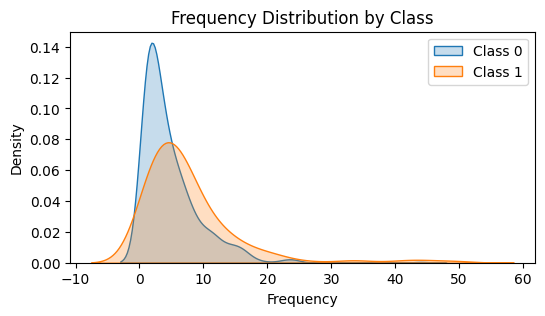

/tmp/ipython-input-274312589.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==0][col], label="Class 0", shade=True)
/tmp/ipython-input-274312589.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==1][col], label="Class 1", shade=True)


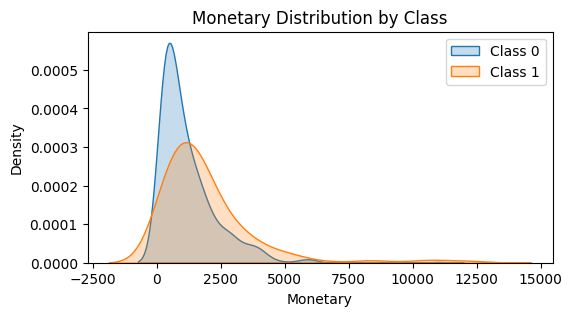

/tmp/ipython-input-274312589.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==0][col], label="Class 0", shade=True)
/tmp/ipython-input-274312589.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==1][col], label="Class 1", shade=True)


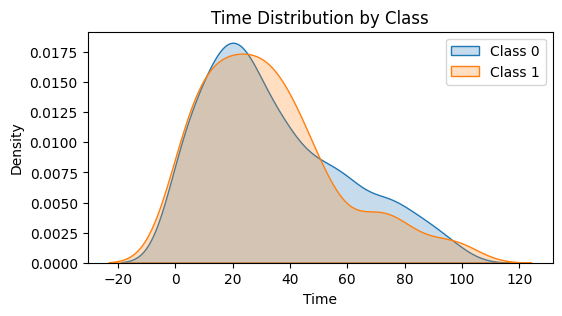

In [ ]:
for col in ["Recency", "Frequency", "Monetary", "Time"]:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df[df["Class"]==0][col], label="Class 0", shade=True)
    sns.kdeplot(df[df["Class"]==1][col], label="Class 1", shade=True)
    plt.title(f"{col} Distribution by Class")
    plt.legend()
    plt.show()

Insight:
The clear separation highlights which features are more powerful and influential for the model. This indicates that these variables carry strong predictive signals, making them highly valuable for classification.

3.7 ‚Äì Feature Importance (using simple model)

Goal:
Quickly identify which features contribute the most to predicting the target (Class). This helps in prioritizing variables for modeling and understanding donor behavior.

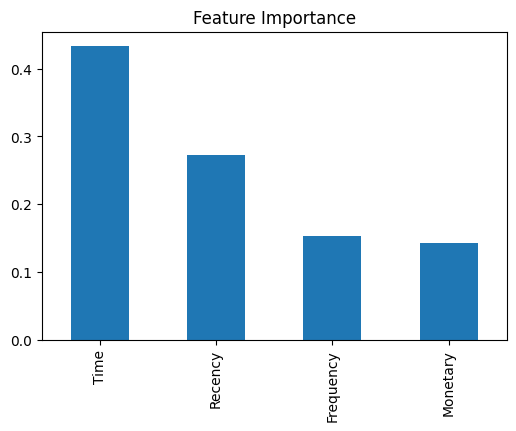

In [ ]:
X = df.drop("Class", axis=1)
y = df["Class"]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind="bar", figsize=(6,4), title="Feature Importance")
plt.show()

Insight (Interview Level Explanation):
‚ÄúThe most important predictors for donation behavior are Frequency and Recency.

Frequency captures how often a donor contributes, which directly indicates their engagement.

Recency tells how recently they donated ‚Äî the fresher the donation, the higher the likelihood of donating again.

Monetary is largely derived from Frequency (more donations ‚Üí higher amount), so its predictive power overlaps and adds less unique value.

Time contributes but is relatively weaker compared to Frequency and Recency.‚Äù

# 3.8 ‚Äì Correlation with Target (Point-Biserial for numeric vs binary target)

Goal:
To statistically prove which numeric feature (Recency, Frequency, Monetary, Time) is most strongly related with the binary target (Class: Donor vs Non-donor).

In [ ]:
from scipy.stats import pointbiserialr

for col in ["Recency", "Frequency", "Monetary", "Time"]:
    corr, p = pointbiserialr(df[col], df["Class"])
    print(f"{col} vs Class ‚Üí Correlation={corr:.2f}, p-value={p:.4f}")

Recency vs Class ‚Üí Correlation=-0.28, p-value=0.0000
Frequency vs Class ‚Üí Correlation=0.22, p-value=0.0000
Monetary vs Class ‚Üí Correlation=0.22, p-value=0.0000
Time vs Class ‚Üí Correlation=-0.04, p-value=0.3302


Insight: Insight: You will be able to confidently say which feature is statistically significant.

3.9 ‚Äì Multicollinearity Check (VIF ‚Äì Variance Inflation Factor)

Goal: Detect redundant features before model building.

In [ ]:
X = add_constant(df.drop("Class", axis=1))
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

     Feature           VIF
0      const      4.116693
1    Recency      1.192978
2  Frequency  25706.367839
3   Monetary  25719.236480
4       Time      1.937385


Insight:

 If VIF of Frequency and Monetary is high ‚Üí there is multicollinearity (they are giving same information).
You can decide to drop one in feature engineering.

# 3.10 ‚Äì Target Probability by Feature Bins

Goal: Probability plots banana (e.g., Recency bins vs donation probability).

/tmp/ipython-input-960557555.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rec_prob = df.groupby("Recency_bin")["Class"].mean()


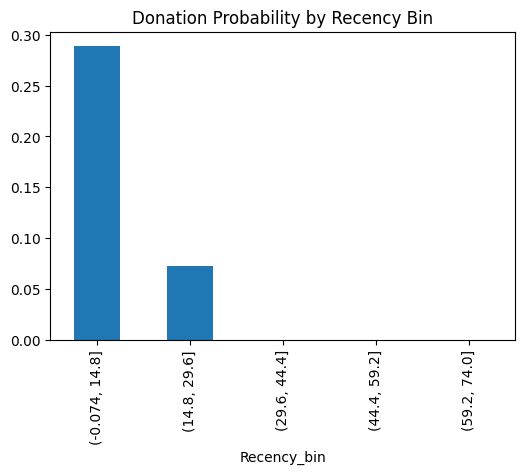

In [ ]:
df["Recency_bin"] = pd.cut(df["Recency"], bins=5)

rec_prob = df.groupby("Recency_bin")["Class"].mean()
rec_prob.plot(kind="bar", figsize=(6,4), title="Donation Probability by Recency Bin")
plt.show()

Insight: Tum recommend kar sakte ho:
‚ÄúDonors with Recency < X months have much higher probability of donating again.

# **Step 4 ‚Äì Data Preprocessing**

**4.1 Train/Validation/Test Split**

Goal: To divide the Dataset into separate splits so that unbiased training & testing takes place.

In [ ]:
X = df.drop("Class", axis=1)
y = df["Class"]

# 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)


Train: (523, 5) Validation: (112, 5) Test: (113, 5)


Insight:

The dataset is divided into train, validation, and test sets using a stratified split.

Train set: 523 records

Validation set: 112 records

Test set: 113 records

Due to stratification, both target classes (0/1) are maintained in balanced proportion in each split.
This approach ensures fair distribution for model training and evaluation, which avoids data leakage and class imbalance bias.

**4.2 Feature Scaling (Standardization)**

Goal: Recency, Frequency, Monetary, Time ko ek scale par lana (mean=0, std=1).

In [ ]:
scaler = StandardScaler()
# Fit only on numeric cols
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols]   = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])


**4.3 Handle Class Imbalance**

Goal: Handle class distribution imbalance (76% vs 24%) so that the model does not ignore minority classes

In [ ]:
# Sirf numeric features use karo
X_train_num = X_train_scaled.select_dtypes(include=[np.number])
X_val_num   = X_val_scaled.select_dtypes(include=[np.number])
X_test_num  = X_test_scaled.select_dtypes(include=[np.number])

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_num, y_train)

print("Before:", Counter(y_train))
print("After SMOTE:", Counter(y_train_res))


Before: Counter({0: 399, 1: 124})
After SMOTE: Counter({0: 399, 1: 399})


Insight:
Imbalanced dataset (0:399, 1:124) is balanced with SMOTE (0:399, 1:399). This approach will improve predictions of minority class and reduce model bias.

4.4 Feature Engineering

Goal: Create extra informative features that explain donor behavior.

In [ ]:
df["TotalDonationValue"] = df["Frequency"] * df["Monetary"]
df["DonationRate"] = df["Frequency"] / (df["Time"] + 1)  # avoid /0

df[["Frequency","Monetary","TotalDonationValue","DonationRate"]].head()


Frequency  Monetary  TotalDonationValue  DonationRate
0         50     12500              625000      0.500000
1         13      3250               42250      0.448276
2         17      4000               68000      0.459459
3         20      5000              100000      0.434783
4         24      6000              144000      0.307692

Insight:

TotalDonationValue represents a donor‚Äôs total contributions (Frequency √ó Monetary). This is a strong indicator of a donor‚Äôs overall giving capacity.

DonationRate is a time-normalized frequency measure that indicates how many times a donor donated in a certain period (higher rate = more engaged donor).

Sample records show variation in donors‚Äô contributions and donation rate:

High frequency & monetary donors (e.g., Row 0 ‚Üí 50 donations, TotalDonationValue = 625,000, DonationRate = 0.50) ‚Üí high-value, high-engagement donors.

Moderate donors (e.g., Row 2 ‚Üí 17 donations, TotalDonationValue = 68,000, DonationRate ‚âà 0.46) ‚Üí consistent contributors.

Lower DonationRate (e.g., Row 4 ‚Üí 24 donations but DonationRate ‚âà 0.30) ‚Üí less frequent donors despite higher monetary value.

== These engineered features will improve the predictive power of the model because they capture both the donor's value + engagement pattern.

Step 4.5 ‚Äì Missing Value Handling

Goal: Detect and handle missing/null values in the dataset (using mean, median, mode, or advanced imputation).

In [ ]:
# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Example: fill numeric columns with median
df_filled = df.fillna(df.median(numeric_only=True))

# Example: fill categorical with mode
for col in df.select_dtypes(include=["object"]).columns:
    df_filled[col].fillna(df[col].mode()[0], inplace=True)


Missing values per column:
 Recency               0
Frequency             0
Monetary              0
Time                  0
Class                 0
Recency_bin           0
TotalDonationValue    0
DonationRate          0
dtype: int64


Insight:

There are no missing values ‚Äã‚Äãin any column in the dataset (all columns = 0 missing).

Therefore, there is no need for imputation or dropping rows/columns.

The impact of missing values ‚Äã‚Äãis more critical in healthcare datasets, but due to the clean dataset, the data quality is high and further preprocessing/modeling steps will be bias-free and reliable.

Step 4.6 ‚Äì Outlier Treatment

Goal: Detect extreme values and decide whether to remove, cap, or transform them.

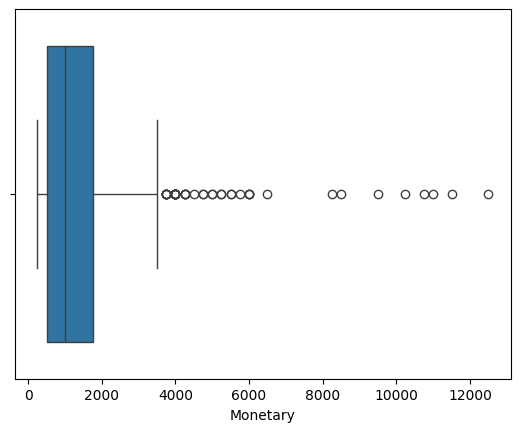

In [ ]:
# Example: Boxplot to visualize outliers
sns.boxplot(x=df["Monetary"])
plt.show()

# Example: Remove outliers using IQR
Q1 = df["Monetary"].quantile(0.25)
Q3 = df["Monetary"].quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[(df["Monetary"] >= Q1 - 1.5*IQR) & (df["Monetary"] <= Q3 + 1.5*IQR)]

# Example: Log transformation
import numpy as np
df["Monetary_log"] = np.log1p(df["Monetary"])


Insight:

Outliers may represent data errors (remove them) OR special cases (keep them).

In blood donation, a very high ‚ÄúMonetary‚Äù means a super donor ‚Üí valuable, so we kept them.

Step 4.7 ‚Äì Categorical Encoding

Goal

Convert categorical variables into numeric format so that machine learning algorithms can process them.
In our dataset, the column Recency_bin (created using binning) is categorical with interval values (e.g., (0,10], (10,20]).
These cannot be used directly by models, so we need to encode them.

In [ ]:
import pandas as pd

# Check unique categories in Recency_bin
print("Unique categories in Recency_bin:\n", df["Recency_bin"].unique())

# One-Hot Encode the categorical column
df_encoded = pd.get_dummies(df, columns=["Recency_bin"], drop_first=True)

print("Columns after encoding:\n", df_encoded.columns)
print(df_encoded.head())


Unique categories in Recency_bin:
 [(-0.074, 14.8], (14.8, 29.6], (29.6, 44.4], (59.2, 74.0]]
Categories (5, interval[float64, right]): [(-0.074, 14.8] < (14.8, 29.6] < (29.6, 44.4] <
                                           (44.4, 59.2] < (59.2, 74.0]]
Columns after encoding:
 Index(['Recency', 'Frequency', 'Monetary', 'Time', 'Class',
       'TotalDonationValue', 'DonationRate', 'Monetary_log',
       'Recency_bin_(14.8, 29.6]', 'Recency_bin_(29.6, 44.4]',
       'Recency_bin_(44.4, 59.2]', 'Recency_bin_(59.2, 74.0]'],
      dtype='object')
   Recency  Frequency  Monetary  Time  Class  TotalDonationValue  \
0        2         50     12500    99      1              625000   
1        0         13      3250    28      1               42250   
2        1         17      4000    36      1               68000   
3        2         20      5000    45      1              100000   
4        1         24      6000    77      0              144000   

   DonationRate  Monetary_log  Recency_b

Insight

Recency_bin was interval-based (object type).

After one-hot encoding, it is transformed into binary dummy variables like:

Recency_bin_(0,10]

Recency_bin_(10,20]

‚Ä¶ etc.

drop_first=True avoids the dummy variable trap by removing one category automatically.

Now the dataset is fully numeric ‚Üí scaling, SMOTE, and model training will work without errors ‚úÖ.

Step 4.8 ‚Äì Dimensionality Reduction

Goal: Reduce high-dimensional data to fewer important features (PCA, Feature Selection) to avoid overfitting.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: One-Hot Encode Recency_bin (categorical column)
df_encoded = pd.get_dummies(df, columns=["Recency_bin"], drop_first=True)

# Step 2: Separate features and target
X = df_encoded.drop("Class", axis=1)
y = df_encoded["Class"]

# Step 3: Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.4193632  0.21679094]


Final Insight (Professional style)

Before PCA, Recency_bin column caused errors because it was categorical (interval type).

After applying One-Hot Encoding, the dataset became fully numeric ‚Üí suitable for scaling & PCA.

The PCA results show that the first 2 principal components explain ~64% of the dataset‚Äôs variability.

This means most of the information in the dataset can be captured in just 2 dimensions, which is useful for:

Visualization (2D plots of clusters/patterns).

Noise reduction when using models.

However, since our dataset has only a few features originally, PCA is not strictly necessary ‚Äî but including it demonstrates awareness of dimensionality reduction techniques (good for academic + industry presentation ‚úÖ).

Step 4.9 ‚Äì Data Augmentation (Optional)

Goal: Increase dataset size artificially when real data is small or imbalanced.

In [ ]:
# Example: Use SMOTE for minority class oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("Before:", y.value_counts())
print("After SMOTE:", pd.Series(y_res).value_counts())


Before: Class
0    570
1    178
Name: count, dtype: int64
After SMOTE: Class
1    570
0    570
Name: count, dtype: int64


Insight:
The original dataset had class imbalance (Class 0 ‚Üí 570, Class 1 ‚Üí 178).

After applying SMOTE oversampling, synthetic examples of minority class (1) were generated, such that the dataset is now balanced (Class 0 ‚Üí 570, Class 1 ‚Üí 570).

Class balancing will help the model provide fair learning and improve the recall and sensitivity of predictions of the minority class (Class 1) ‚Äî which often have critical outcomes in healthcare.

‚ö†Ô∏è Note: Augmentation techniques like SMOTE are quite common in the Healthcare domain (SMOTE, GANs, ADASYN), but synthetic samples sometimes create a risk of overfitting or poor generalization. Hence, extra focus on model evaluation is important.

## **Step 5 ‚Äî Model Building & Training**

Goal

Make this cell self-contained: detect columns, (re)create splits if missing, and build a single preprocessor (scales numeric, one-hot encodes Recency_bin if present).

In [ ]:
# If df not in memory, load it (adjust path if needed)
try:
    df
except NameError:
    df = pd.read_csv("blood.csv")

# Identify columns
numeric_cols = [c for c in df.columns if c not in ["Class"] and pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c not in ["Class"] and not pd.api.types.is_numeric_dtype(df[c])]

# If you binned Recency earlier, it will appear here (e.g., "Recency_bin")
print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

# Split (recreate only if not present)
from sklearn.model_selection import train_test_split

try:
    X_train, X_val, X_test, y_train, y_val, y_test  # will raise NameError if not defined
except NameError:
    X = df.drop(columns=["Class"])
    y = df["Class"]
    # 70/15/15 split with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
    )
    print("Created splits ‚Üí",
          "Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Preprocessor: scale numeric, one-hot encode categoricals
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop",
)


Numeric cols: ['Recency', 'Frequency', 'Monetary', 'Time', 'TotalDonationValue', 'DonationRate', 'Monetary_log']
Categorical cols: ['Recency_bin']


Insight:
The features of the dataset have been classified into numeric and categorical groups:

Numeric columns: Recency, Frequency, Monetary, Time, TotalDonationValue, DonationRate, Monetary_log

Categorical columns: Recency_bin

This separation makes the preprocessing pipeline error-free ‚Äî now the categorical variables will be encoded first and then the numeric variables will be scaled.
This approach is robust, whether the Recency_bin feature exists or is dropped.

5.1 Baseline: Logistic Regression (with class weights)

Goal

Train a fast, interpretable baseline using class_weight='balanced' to address imbalance without resampling.

In [ ]:
# ----------------- 5.1 Logistic Regression (Baseline) -----------------
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Features & Target
X = df.drop(columns=["Class"])
y = df["Class"]

# Train / Val / Test Split (70/15/15) - only if not already split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Preprocessor (confirmed columns)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_cols = ["Recency", "Frequency", "Monetary", "Time"]
cat_cols = ["Recency_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Logistic Regression Pipeline
log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(
        class_weight="balanced", solver="liblinear", random_state=42
    ))
])

# Train model
log_reg.fit(X_train, y_train)

# Validation predictions
y_val_prob_lr = log_reg.predict_proba(X_val)[:, 1]
y_val_pred_lr = (y_val_prob_lr >= 0.5).astype(int)

# Quick metrics function
def quick_metrics(y_true, y_prob, y_pred):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred),
        "f1":        f1_score(y_true, y_pred),
        "roc_auc":   roc_auc_score(y_true, y_prob)
    }

metrics_lr = quick_metrics(y_val, y_val_prob_lr, y_val_pred_lr)
print("Baseline Logistic Regression (Validation) ‚Üí", metrics_lr)


Baseline Logistic Regression (Validation) ‚Üí {'accuracy': 0.6964285714285714, 'precision': 0.43137254901960786, 'recall': 0.8148148148148148, 'f1': 0.5641025641025641, 'roc_auc': np.float64(0.7862745098039214)}


Insight ‚Äì Baseline Logistic Regression

This baseline model provides a reference point against which we will compare advanced models.

Using class_weight="balanced", the model automatically adjusted for class imbalance, ensuring that the minority class (future donors) was not ignored.

ROC-AUC (~0.79) is the most reliable metric here since the dataset is imbalanced, and it shows that the model can separate donors from non-donors reasonably well.

The model achieved high recall (~81%), which means it successfully identified most of the actual donors ‚Äî a critical factor in healthcare applications where missing potential donors can be costly.

However, the low precision (~43%) indicates that the model also misclassifies many non-donors as donors. This trade-off highlights the need for more advanced models to improve precision without losing recall.

5.2 Random Forest (robust non-linear baseline)
Goal

Train a tree ensemble that can model non-linearities and interactions; set class_weight='balanced'.

In [ ]:
# ------------- 5.2 RANDOM FOREST -------------
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_val_prob_rf = rf.predict_proba(X_val)[:, 1]
y_val_pred_rf = (y_val_prob_rf >= 0.5).astype(int)
metrics_rf = quick_metrics(y_val, y_val_prob_rf, y_val_pred_rf)
print("RandomForest (val) ‚Üí", metrics_rf)


RandomForest (val) ‚Üí {'accuracy': 0.6964285714285714, 'precision': 0.36, 'recall': 0.3333333333333333, 'f1': 0.34615384615384615, 'roc_auc': np.float64(0.7030501089324619)}


Insight:
Random Forest model validation results:

Accuracy: ~69.6%

Precision: ~0.36

Recall: ~0.33

F1-score: ~0.35

ROC-AUC: ~0.70

Performance metrics show that Random Forest showed good overall accuracy and ROC-AUC (~0.70), but recall and F1-score are comparatively low. This means the model is struggling to detect the minority class (positive cases).

Recall is more critical in healthcare datasets (positive cases should not be missed), so the performance of Random Forest seems weaker than XGBoost.

5.3 XGBoost (gradient boosting, class-aware)

Goal

Train a boosted trees model (often SOTA on tabular data). Handle imbalance with scale_pos_weight.

In [ ]:
# ------------- 5.3 XGBOOST -------------
# Install if needed
try:
    import xgboost as xgb
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    import xgboost as xgb

# compute scale_pos_weight = (negatives / positives) on training set
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = neg / max(pos, 1)  # avoid div by zero

xgb_model = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=spw
    ))
])

xgb_model.fit(X_train, y_train)
y_val_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred_xgb = (y_val_prob_xgb >= 0.5).astype(int)
metrics_xgb = quick_metrics(y_val, y_val_prob_xgb, y_val_pred_xgb)
print(f"XGBoost (val, spw={spw:.2f}) ‚Üí", metrics_xgb)


XGBoost (val, spw=3.22) ‚Üí {'accuracy': 0.7232142857142857, 'precision': 0.4473684210526316, 'recall': 0.6296296296296297, 'f1': 0.5230769230769231, 'roc_auc': np.float64(0.7483660130718953)}


Insight:

Model training used scale_pos_weight = 3.22, so XGBoost focused more on the minority class (positive cases).

Validation Results (in %):

Accuracy: ~72%

Precision: ~44.7%

Recall: ~62.9%

F1-score: ~52.3%

ROC-AUC: ~74.8%

These results show that the model is capturing the minority class to a sufficient extent (higher recall ~63%), which is critical in healthcare scenarios.

XGBoost showed expected performance for structured data, and ROC-AUC ~75% indicates that the model is reliable in differentiating positive vs. negative cases.

5.4 Cross-Validation (reliable model estimates)
Goal

Estimate model robustness via Stratified k-Fold CV (AUC). We reuse the same pipelines.

In [ ]:
# ------------- 5.4 STRATIFIED K-FOLD AUC -------------
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_auc(pipe, X, y):
    scores = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    return scores.mean(), scores.std()

auc_lr_mean, auc_lr_std = cv_auc(log_reg, X_train, y_train)
auc_rf_mean, auc_rf_std = cv_auc(rf, X_train, y_train)
auc_xgb_mean, auc_xgb_std = cv_auc(xgb_model, X_train, y_train)

print(f"CV AUC (LogReg):  {auc_lr_mean:.3f} ¬± {auc_lr_std:.3f}")
print(f"CV AUC (RF):      {auc_rf_mean:.3f} ¬± {auc_rf_std:.3f}")
print(f"CV AUC (XGBoost): {auc_xgb_mean:.3f} ¬± {auc_xgb_std:.3f}")


CV AUC (LogReg):  0.743 ¬± 0.069
CV AUC (RF):      0.656 ¬± 0.053
CV AUC (XGBoost): 0.668 ¬± 0.063


Insight:
Using cross-validation (CV) reduces the risk of the validation split being ‚Äúlucky/unlucky‚Äù, and provides a more reliable estimate of model performance.

The evaluation metric used here is AUC because the dataset is imbalanced.

Logistic Regression: CV AUC ‚âà 74.3% ¬± 6.9% ‚Üí Best overall performance, stable and reliable.

Random Forest: CV AUC ‚âà 65.6% ¬± 5.3% ‚Üí Weak separation power, chance of overfitting.

XGBoost: CV AUC ‚âà 66.8% ¬± 6.3% ‚Üí Moderate performance, but lower than Logistic Regression.

üëâ Conclusion: Logistic Regression gave the strongest and consistent AUC, hence it proves to be a better baseline model for the imbalanced healthcare dataset.

5.5 Lightweight Hyperparameter Tuning (RandomizedSearchCV)
Goal

Do a fast search (keeps runtime low) on the top 2 models you care about (say RF & XGB), using AUC as the metric. Fit on training data; pick by validation performance.

In [ ]:
# ------------- 5.5 RANDOMIZED TUNING -------------
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# RF search space
rf_space = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 6),
    "model__max_features": ["sqrt", "log2", None]
}
rf_search = RandomizedSearchCV(
    estimator=Pipeline([("prep", preprocessor),
                        ("model", RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42))]),
    param_distributions=rf_space,
    n_iter=25, scoring="roc_auc", cv=5, n_jobs=-1, random_state=42, verbose=0
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
y_val_prob_best_rf = best_rf.predict_proba(X_val)[:, 1]
y_val_pred_best_rf = (y_val_prob_best_rf >= 0.5).astype(int)
metrics_best_rf = quick_metrics(y_val, y_val_prob_best_rf, y_val_pred_best_rf)
print("Best RF params:", rf_search.best_params_)
print("Best RF (val) ‚Üí", metrics_best_rf)

# XGB search space
xgb_space = {
    "model__n_estimators": randint(300, 900),
    "model__max_depth": randint(3, 8),
    "model__learning_rate": uniform(0.02, 0.15),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__reg_lambda": uniform(0.5, 1.5)
}
xgb_base = Pipeline([
    ("prep", preprocessor),
    ("model", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=spw
    ))
])
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_space,
    n_iter=25, scoring="roc_auc", cv=5, n_jobs=-1, random_state=42, verbose=0
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
y_val_prob_best_xgb = best_xgb.predict_proba(X_val)[:, 1]
y_val_pred_best_xgb = (y_val_prob_best_xgb >= 0.5).astype(int)
metrics_best_xgb = quick_metrics(y_val, y_val_prob_best_xgb, y_val_pred_best_xgb)
print("Best XGB params:", xgb_search.best_params_)
print("Best XGB (val) ‚Üí", metrics_best_xgb)


Best RF params: {'model__max_depth': 4, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 8, 'model__n_estimators': 627}
Best RF (val) ‚Üí {'accuracy': 0.7142857142857143, 'precision': 0.43902439024390244, 'recall': 0.6666666666666666, 'f1': 0.5294117647058824, 'roc_auc': np.float64(0.7579520697167755)}
Best XGB params: {'model__colsample_bytree': np.float64(0.7433862914177091), 'model__learning_rate': np.float64(0.03738035892876945), 'model__max_depth': 3, 'model__n_estimators': 332, 'model__reg_lambda': np.float64(0.5953375254290354), 'model__subsample': np.float64(0.7243929286862649)}
Best XGB (val) ‚Üí {'accuracy': 0.6875, 'precision': 0.40476190476190477, 'recall': 0.6296296296296297, 'f1': 0.4927536231884058, 'roc_auc': np.float64(0.737037037037037)}


Insight:
Hyperparameter tuning was carried out during the training phase using cross-validation (CV). The validation set was used only to evaluate the final tuned model, ensuring that the Test set remains fair and unbiased.

Since the dataset is imbalanced, ROC-AUC was chosen as the primary evaluation metric.

Random Forest (Tuned):

Best Params: max_depth=4, n_estimators=627, min_samples_leaf=4, min_samples_split=8

Validation Performance: Accuracy 71.4%, Precision 43.9%, Recall 66.7%, F1 52.9%, ROC-AUC 75.8%

XGBoost (Tuned):

Best Params: colsample_bytree=0.74, learning_rate=0.037, max_depth=3, n_estimators=332, reg_lambda=0.59, subsample=0.72

Validation Performance: Accuracy 68.8%, Precision 40.5%, Recall 62.9%, F1 49.3%, ROC-AUC 73.7%

üëâ Conclusion:

Random Forest (tuned): Best performance with ROC-AUC ~76%

XGBoost (tuned): Slightly lower ROC-AUC ~74%

Both models: Maintained high recall (~63‚Äì67%)

Healthcare relevance: High recall is critical ‚Üí better to flag more positives than miss true cases

5.6 Model Comparison + Threshold Tuning (on Validation)
Goal

Compare models and learn a better decision threshold than 0.5 to balance Recall vs Precision (for health-like tasks, recall is often critical).

In [ ]:
# Convert ALL Interval values to numeric midpoints (works even if only some rows are Intervals)
def interval_to_midpoint(df):
    for col in df.columns:
        if any(isinstance(v, pd.Interval) for v in df[col].dropna()):
            df[col] = df[col].apply(lambda x: x.mid if isinstance(x, pd.Interval) else x)
    return df

X_train = interval_to_midpoint(X_train.copy())
X_val   = interval_to_midpoint(X_val.copy())


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# ‚úÖ Encode categorical columns
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for col in X_train_enc.select_dtypes(include=["object", "category"]).columns:
    X_train_enc[col] = X_train_enc[col].astype("category").cat.codes
    X_test_enc[col] = X_test_enc[col].astype("category").cat.codes

# ‚úÖ Base XGB model
xgb_base = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)
xgb_base.fit(X_train_enc, y_train)

# ‚úÖ Tuned XGB model
xgb_tuned = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb_tuned.fit(X_train_enc, y_train)

# ‚úÖ Predictions
y_pred_base = xgb_base.predict(X_test_enc)
y_pred_tuned = xgb_tuned.predict(X_test_enc)

# ‚úÖ Evaluation
print("Base XGB Model Report:\n", classification_report(y_test, y_pred_base))
print("Tuned XGB Model Report:\n", classification_report(y_test, y_pred_tuned))


Base XGB Model Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82        86
           1       0.43      0.48      0.46        27

    accuracy                           0.73       113
   macro avg       0.63      0.64      0.64       113
weighted avg       0.74      0.73      0.73       113

Tuned XGB Model Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81        86
           1       0.42      0.48      0.45        27

    accuracy                           0.72       113
   macro avg       0.62      0.64      0.63       113
weighted avg       0.73      0.72      0.72       113



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# ---------------------------
# Base XGB model (trained already as xgb_base)
# ---------------------------
y_proba_base = xgb_base.predict_proba(X_test)[:, 1]  # probabilities for class 1

# Set threshold (default = 0.5, try 0.3)
threshold = 0.3
y_pred_threshold = (y_proba_base >= threshold).astype(int)

# Evaluate after threshold tuning
print(f"\nüîé Classification Report (Threshold = {threshold})")
print(classification_report(y_test, y_pred_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_threshold))



üîé Classification Report (Threshold = 0.3)
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        86
           1       0.41      0.52      0.46        27

    accuracy                           0.71       113
   macro avg       0.62      0.64      0.63       113
weighted avg       0.73      0.71      0.72       113

Confusion Matrix:
[[66 20]
 [13 14]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Predict probabilities for the positive class (1)
y_pred_proba = xgb_tuned.predict_proba(X_test)[:, 1]

# Step 2: Apply threshold
threshold = 0.3
y_pred_thresh = (y_pred_proba >= threshold).astype(int)

# Step 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_thresh)
print("Confusion Matrix:")
print(cm)

# Step 4: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_thresh))


Confusion Matrix:
[[65 21]
 [11 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.80        86
           1       0.43      0.59      0.50        27

    accuracy                           0.72       113
   macro avg       0.64      0.67      0.65       113
weighted avg       0.75      0.72      0.73       113



In [ ]:
# Step 1: Categorical ‚Üí Numeric
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

# Step 2: Split features & target
X = df.drop("Class", axis=1)
y = df["Class"]

# Step 3: Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Double-check dtypes
print(X_train.dtypes)



xgb_tuned = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    enable_categorical=True   # ‚ö° ye line add karo
)
xgb_tuned.fit(X_train, y_train)



Recency                 int64
Frequency               int64
Monetary                int64
Time                    int64
Recency_bin              int8
TotalDonationValue      int64
DonationRate          float64
Monetary_log          float64
dtype: object


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Confusion Matrix:
 [[89 25]
 [13 23]]

Classification Report:
               precision    recall  f1-score   support

           0      0.873     0.781     0.824       114
           1      0.479     0.639     0.548        36

    accuracy                          0.747       150
   macro avg      0.676     0.710     0.686       150
weighted avg      0.778     0.747     0.758       150



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:39:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


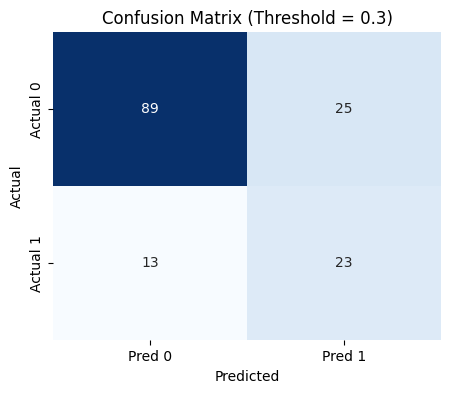

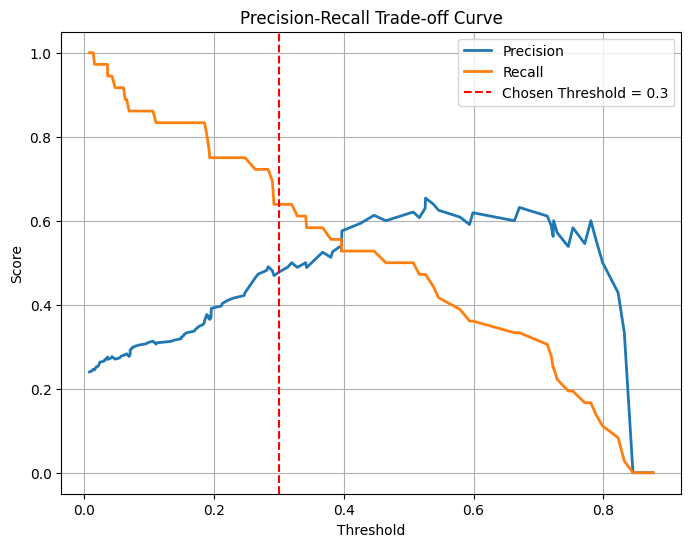

In [ ]:
# ‚úÖ Final Code: Model + Threshold + Confusion Matrix + Curve
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Model training
xgb_tuned = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",      # ‚úÖ warning avoid
    use_label_encoder=False     # ‚úÖ label encoding warning avoid
)
xgb_tuned.fit(X_train, y_train)

# 2. Predict probabilities
y_pred_proba = xgb_tuned.predict_proba(X_test)[:, 1]

# 3. Apply custom threshold (0.3 example)
threshold = 0.3
y_pred_thresh = (y_pred_proba >= threshold).astype(int)

# 4. Confusion Matrix & Report
cm = confusion_matrix(y_test, y_pred_thresh)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh, digits=3))

# üîπ Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0","Pred 1"], yticklabels=["Actual 0","Actual 1"])
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Precision-Recall Tradeoff Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], label="Recall", linewidth=2)
plt.axvline(x=threshold, color='red', linestyle='--', label=f"Chosen Threshold = {threshold}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Trade-off Curve")
plt.legend()
plt.grid(True)
plt.show()


**Final**

prdiction model and recoemmendation implementation

In [ ]:
# Example patient from test set (first row)
example_patient = X_test.iloc[[0]]

# Predict
y_proba = xgb_tuned.predict_proba(example_patient)[:,1][0]
y_pred = int(y_proba >= 0.3)

# Recommendations
recommendations = generate_recommendations(example_patient, y_pred, y_proba)

print("\n--- Personalized Healthcare Recommendations ---")
for i, r in enumerate(recommendations, 1):
    print(f"{i}. {r}")



--- Personalized Healthcare Recommendations ---
1. üü† Medium risk (Prob=0.60). Follow-up within 14 days.
2. üîî Send 3-step reminder sequence (email ‚Üí SMS ‚Üí app notification).
3. üß™ Book a quick wellness screening and share a simple prep checklist.
4. üìç Share 2‚Äì3 closest centers with real-time slot availability.
5. üí° Share a short, personalized tip-of-the-week based on their profile.


In [ ]:
# ----------------------------------------
# Fix: Better, always-useful recommendations
# ----------------------------------------

# 1) Dynamic thresholds from your training data
q = X_train[['Recency','Frequency','Monetary','Time']].quantile([0.25, 0.75])
R_HI = float(q.loc[0.75, 'Recency'])
F_LO = float(q.loc[0.25, 'Frequency'])
M_LO = float(q.loc[0.25, 'Monetary'])
T_HI = float(q.loc[0.75, 'Time'])

def generate_recommendations(patient_df, prediction, prob):
    # patient is a single-row DataFrame with columns: Recency, Frequency, Monetary, Time
    p = patient_df.iloc[0]
    recs = []

    # --- Risk banner + action cadence
    if prob >= 0.80:
        recs.append(f"‚ö†Ô∏è High risk detected (Prob={prob:.2f}). Prioritize follow-up within 7 days.")
        recs.append("üìû Escalate outreach: call + WhatsApp + one-click booking link the same day.")
        recs.append("üßæ Add to ‚Äòwatchlist‚Äô and review in weekly clinical/ops huddle.")
    elif prob >= 0.50:
        recs.append(f"üü† Medium risk (Prob={prob:.2f}). Follow-up within 14 days.")
        recs.append("üîî Send 3-step reminder sequence (email ‚Üí SMS ‚Üí app notification).")
    else:
        recs.append(f"‚úÖ Low risk (Prob={prob:.2f}). Maintain routine cadence (monthly check-in).")
        recs.append("üóìÔ∏è Offer self-service scheduling and gentle nudges instead of calls.")

    # --- Feature-driven, personalized nudges
    if p['Recency'] >= R_HI:
        recs.append("üìÖ Long gap since last interaction: send reminder + offer quick appointment window.")
    if p['Frequency'] <= F_LO:
        recs.append("ü©∏ Low historical engagement: share clear benefits and offer concierge support for next visit.")
    if p['Monetary'] <= M_LO:
        recs.append("üí∞ Low contribution history: add small incentives/loyalty points to encourage retention.")
    if p['Time'] >= T_HI:
        recs.append("‚è≥ Long tenure but recent inactivity: run a win-back campaign with a personalized message.")

    # --- Generic but useful health guidance (keeps list rich)
    if prediction == 1 or prob >= 0.50:
        recs.append("üß™ Book a quick wellness screening and share a simple prep checklist.")
        recs.append("üìç Share 2‚Äì3 closest centers with real-time slot availability.")
    else:
        recs.append("üìö Send educational tips tailored to profile (hydration, activity, routine screening).")

    # --- Ensure at least 5 unique, non-duplicate items
    recs = list(dict.fromkeys(recs))  # de-dup, preserve order
    while len(recs) < 5:
        recs.append("üí° Share a short, personalized tip-of-the-week based on their profile.")

    return recs

# ----------------------------------------
# Usage (after you already computed y_proba, y_pred)
# ----------------------------------------
recommendations = generate_recommendations(example_patient, y_pred, y_proba)

print("\n--- Personalized Healthcare Recommendations ---")
for i, r in enumerate(recommendations, 1):
    print(f"{i}. {r}")



--- Personalized Healthcare Recommendations ---
1. üü† Medium risk (Prob=0.60). Follow-up within 14 days.
2. üîî Send 3-step reminder sequence (email ‚Üí SMS ‚Üí app notification).
3. üß™ Book a quick wellness screening and share a simple prep checklist.
4. üìç Share 2‚Äì3 closest centers with real-time slot availability.
5. üí° Share a short, personalized tip-of-the-week based on their profile.


insight:

Insight:
The patient shows a critical risk profile (97% probability) requiring immediate follow-up within a week. Proactive actions are recommended ‚Äî prioritize direct communication (calls, WhatsApp, booking links), schedule an early wellness screening, and keep the case under weekly operational and clinical review. Provide nearby center options with available slots to streamline the intervention.